# Training and validating on simulated data

In this notebook we go through the construction of a training and a testing dataset as has been done in the article.

We then train our model and finally validate it with the testing dataset.



In [25]:
import numpy as np
import mccd.auxiliary_fun as mccd_aux
import mccd
from astropy.io import fits

import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [31]:
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 20}
mpl.rc('font', **font)

plot_style = {
                'figure.figsize': (6,6),
                'figure.dpi': 100,
                'figure.autolayout':True,
                'lines.linewidth': 4,
                'lines.linestyle': '-',
                'lines.marker': 'o',
                'lines.markersize': 10,
                'legend.fontsize': 20,
                'legend.loc': 'best',
                'axes.titlesize': 24,
                'axes.grid': False,
                'axes.grid.which': 'major',
                'axes.grid.axis': 'both'}
mpl.rcParams.update(plot_style)

def plot_fun(star_img, cmap='gist_stern'):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    im1 = ax1.imshow(star_img, interpolation='None',cmap=cmap)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im1, cax=cax, extend='both')
    cbar.minorticks_on()
    fig.tight_layout()
    ax1.set_xticks([]);ax1.set_yticks([])
    ax1.axis('off')
    plt.show()

loc2glob = mccd.mccd_utils.Loc2Glob()

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

def plot_ccds_fun(positions,mom,title):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    for ccd_it in range(40):
        xs,ys = loc2glob.shift_coord(ccd_it)
        rect = mpl.patches.Rectangle((xs,ys),2048,4612,linewidth=1,edgecolor='r',facecolor='none')
        ax1.add_patch(rect)

    im1 = ax1.scatter(positions[:, 0], positions[:, 1], s=5,c=mom, marker='*', cmap=newcmp)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax1.set_xticks([]);ax1.set_yticks([])
    ax1.axis('off')
    ax1.set_title(title)
    plt.show()
    

# Generate training and testing datasets

In [27]:
input_pos_path = './../data/sim_inputs/train_positions.npy'
input_ccd_path = './../data/sim_inputs/train_ccd_list.npy'
output_path = './../data/mccd_inputs/'

sim_dataset_generator = mccd_aux.GenerateSimDataset(input_pos_path, input_ccd_path, output_path)

sim_dataset_generator.load_data()
# Posibility to define the simulation parameters
sim_dataset_generator.generate_train_data()  # Using default parameters
# Defining the testing grid
sim_dataset_generator.generate_test_data(x_grid=5, y_grid=10)


In [28]:
# Get the dataset paths
ext = '.fits'
catalog_id = sim_dataset_generator.catalog_id

train_cat_path = output_path + 'train_star_selection-' + str(catalog_id) + ext
test_cat_path = output_path + 'test_star_selection-' + str(catalog_id) + ext


# Check the trainiung dataset

In [29]:
train_cat = fits.open(train_cat_path)[1]

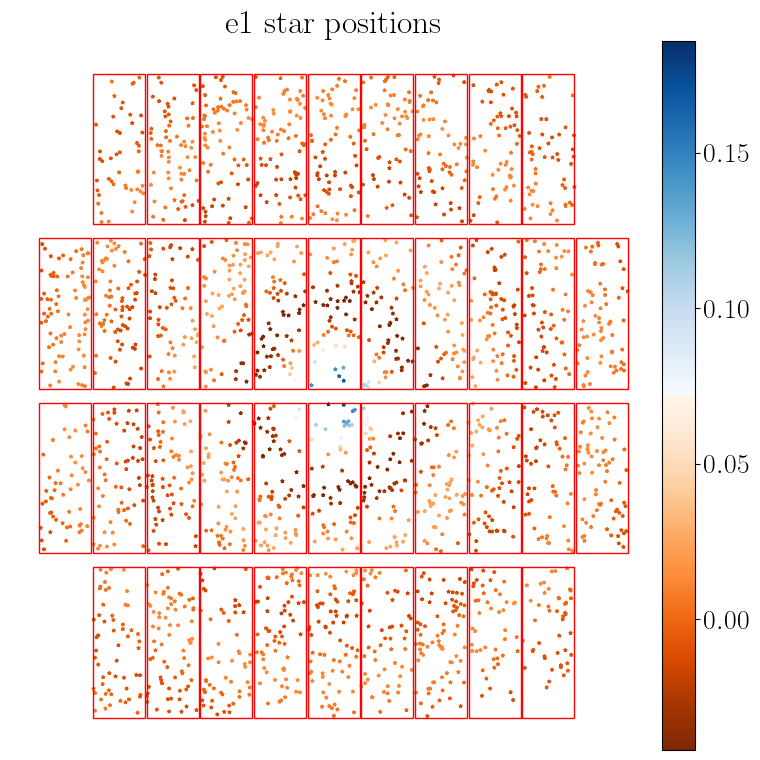

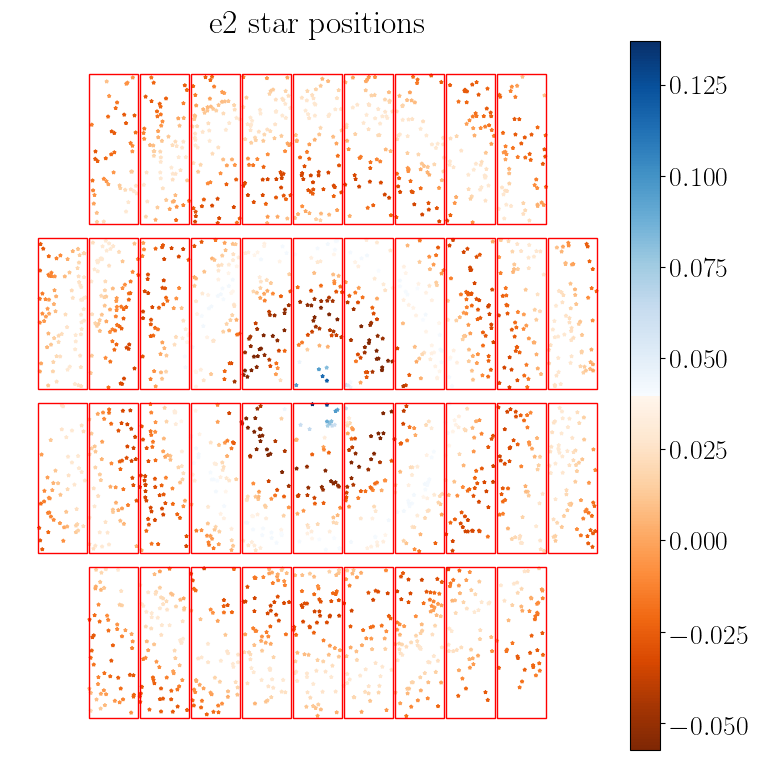

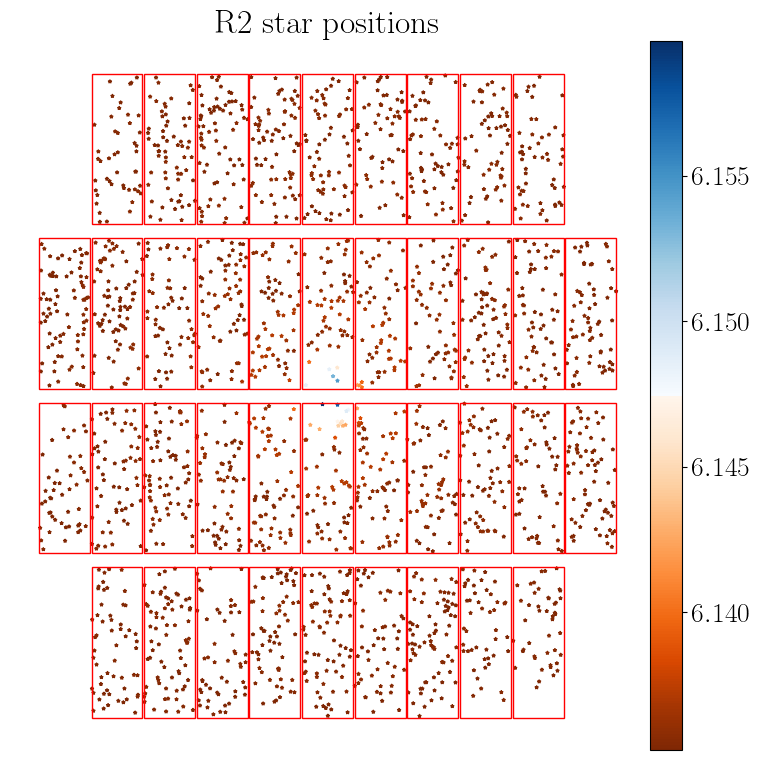

In [32]:
pos = train_cat.data['GLOB_POSITION_IMG_LIST']
plot_ccds_fun(pos,train_cat.data['TRUE_E1_HSM'],'e1 star positions')
plot_ccds_fun(pos,train_cat.data['TRUE_E2_HSM'],'e2 star positions')
plot_ccds_fun(pos,2.*train_cat.data['TRUE_SIG_HSM']**2,'R2 star positions')


# Prepare for the training

We need to prepare the elements we will feed the MCCD algorithm.

- Each input should be a list of elements.
- Each position in the list will correspond to the data from one CCD.
- The CCD id of each position should be included in the ``ccd_list``.


- Data in fits file are concatenated over the first dimension into a large np.ndarray.
- We need to split the data to have it assigned for the corresponding CCD.



In [5]:
# Load the data
train_cat = fits.open(train_cat_path)

In [6]:
train_cat[1].columns

ColDefs(
    name = 'VIGNET_LIST'; format = '2601D'; dim = '(51, 51)'
    name = 'GLOB_POSITION_IMG_LIST'; format = '2D'; dim = '(2,)'
    name = 'MASK_LIST'; format = '2601D'; dim = '(51, 51)'
    name = 'CCD_ID_LIST'; format = '1D'
    name = 'TRUE_E1_HSM'; format = '1D'
    name = 'TRUE_E2_HSM'; format = '1D'
    name = 'TRUE_SIG_HSM'; format = '1D'
)

In [7]:
# Extract the data from the fits catalog 
positions = np.copy(train_cat[1].data['GLOB_POSITION_IMG_LIST'])
stars = np.copy(train_cat[1].data['VIGNET_LIST'])
ccds = np.copy(train_cat[1].data['CCD_ID_LIST']).astype(int)
ccds_unique = np.unique(np.copy(train_cat[1].data['CCD_ID_LIST'])).astype(int)
# Generate the masks
masks = mccd.utils.handle_SExtractor_mask(stars,thresh=-1e5)

# Generate the list format needed by the MCCD package
pos_list = [positions[ccds == ccd] for ccd in ccds_unique]
star_list = [mccd.utils.rca_format(stars[ccds == ccd]) for ccd in ccds_unique]
mask_list = [mccd.utils.rca_format(masks[ccds == ccd]) for ccd in ccds_unique]
ccd_list = [ccds[ccds == ccd].astype(int) for ccd in ccds_unique]
ccd_list = [np.unique(_list)[0].astype(int) for _list in ccd_list]
SNR_weight_list = None  # We wont use any weighting technique as the SNR is constant over the Field of View


# MCCD train parameters

In [8]:
# Parameters

# MCCD instance
n_comp_loc = 8 
d_comp_glob = 8
filters = None
ksig_loc = 1.
ksig_glob = 1.

# MCCD fit
psf_size = 6.15
psf_size_type = 'R2'
n_eigenvects = 5
n_iter_rca = 1
nb_iter_glob = 2 
nb_iter_loc = 2
nb_subiter_S_loc = 100
nb_subiter_A_loc = 500
nb_subiter_S_glob = 30
nb_subiter_A_glob = 200
loc_model = 'hybrid'


# Build the paramter dictionaries
mccd_inst_kw = {'n_comp_loc': n_comp_loc, 'd_comp_glob': d_comp_glob,
                'filters': filters,       'ksig_loc': ksig_loc,
                'ksig_glob':ksig_glob}

mccd_fit_kw = {'psf_size': psf_size,                  'psf_size_type':psf_size_type,
              'n_eigenvects': n_eigenvects,          'nb_iter':n_iter_rca,
              'nb_iter_glob':nb_iter_glob,           'nb_iter_loc':nb_iter_loc,
              'nb_subiter_S_loc':nb_subiter_S_loc,   'nb_subiter_A_loc':nb_subiter_A_loc,
              'nb_subiter_S_glob':nb_subiter_S_glob, 'nb_subiter_A_glob':nb_subiter_A_glob,
              'loc_model':loc_model}

# Launch the training

- Then save the fitted model

In [9]:
# Instanciate the class
mccd_instance = mccd.MCCD(**mccd_inst_kw, verbose=True)
# Launch the training
S, A_loc, A_glob, alpha, pi = mccd_instance.fit(star_list, pos_list, ccd_list, mask_list,
                                                SNR_weight_list, **mccd_fit_kw)

fitted_model_path = output_path + '/fitted_model' + str(catalog_id)
mccd_instance.quicksave(fitted_model_path)


Running basic initialization tasks...
... Done.
Constructing local spatial constraint...


/Users/tliaudat/opt/anaconda3/envs/mccd_env/lib/python3.6/site-packages/mccd-0.0.1-py3.6.egg/mccd/utils.py:522: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


... Done.
Building position polynomials...
... Done.


100% (30 of 30) |########################| Elapsed Time: 0:02:13 Time:  0:02:13
100% (200 of 200) |######################| Elapsed Time: 0:05:43 Time:  0:05:43
100% (30 of 30) |########################| Elapsed Time: 0:02:26 Time:  0:02:26
100% (200 of 200) |######################| Elapsed Time: 0:06:25 Time:  0:06:25
100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
100% (500 of 500) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (100 of 100) |######################| Elapsed Time: 0:00:19 Time:  0:00:19
100% (500 of 500) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (100 of 100) |######################| Elapsed Time: 0:00:19 Time:  0:00:19
100% (500 of 500) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100 of 100) |######################| Elapsed Time: 0:00:20 Time:  0:00:20
100% (500 of 500) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100 of 100) |#####################

# Validation

In [7]:
fitted_model_path = './../data/mccd_inputs/fitted_model2086592.npy'
test_cat_path = './../data/mccd_inputs/test_star_selection-2086592.fits'


In [8]:
# Import
test_cat = fits.open(test_cat_path)[1]
val_dict = mccd_aux.mccd_validation(fitted_model_path, test_cat)


In [9]:
val_dict.keys()

dict_keys(['PSF_VIGNET_LIST', 'PSF_MOM_LIST', 'STAR_MOM_LIST', 'GLOB_POSITION_IMG_LIST', 'VIGNET_LIST', 'MASK_LIST', 'CCD_ID_LIST'])

In [10]:
test_stars = val_dict['VIGNET_LIST']
matched_PSFs = val_dict['PSF_VIGNET_LIST']

e1_psf = val_dict['PSF_MOM_LIST'][:,0]
e2_psf = val_dict['PSF_MOM_LIST'][:,1]
R2_psf = 2.*val_dict['PSF_MOM_LIST'][:,2]**2

e1_star = val_dict['STAR_MOM_LIST'][:,0]
e2_star = val_dict['STAR_MOM_LIST'][:,1]
R2_star = 2.*val_dict['STAR_MOM_LIST'][:,2]**2


In [11]:
pix_RMSE = np.sqrt(np.mean((test_stars - matched_PSFs)**2))
e1_RMSE = np.sqrt(np.mean((e1_star - e1_psf)**2))
e2_RMSE = np.sqrt(np.mean((e2_star - e2_psf)**2))
R2_RMSE = np.sqrt(np.mean(((R2_star - R2_psf)/R2_star)**2))

print('Pixel RMSE = %.5e'%(pix_RMSE))
print('e1 RMSE = %.5e'%(e1_RMSE))
print('e2 RMSE = %.5e'%(e2_RMSE))
print('R2 RMSE = %.5e'%(R2_RMSE))


Pixel RMSE = 6.40913e-05
e1 RMSE = 5.53192e-03
e2 RMSE = 7.70202e-03
R2 RMSE = 8.69793e-03


## Plot a random test star and its model reconstruction

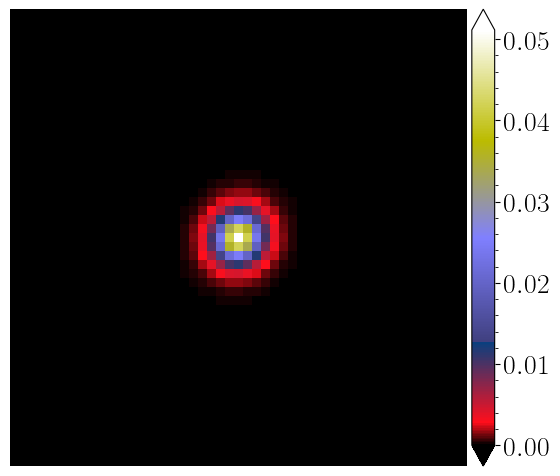

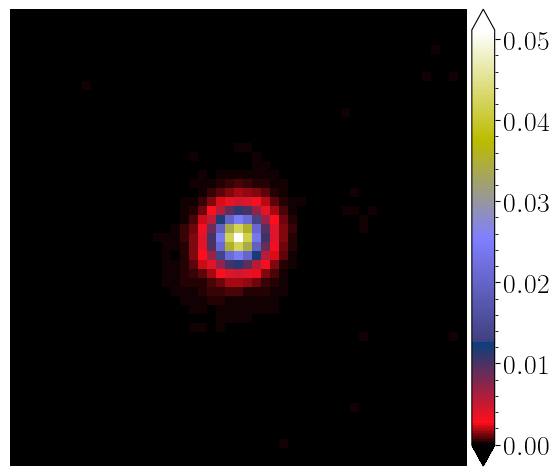

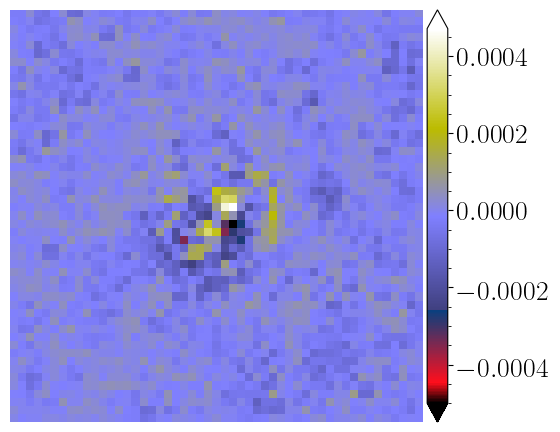

In [21]:
idx = random.randint(0,test_stars.shape[0])

plot_fun(test_stars[idx,:,:])
plot_fun(matched_PSFs[idx,:,:])
plot_fun(test_stars[idx,:,:] - matched_PSFs[idx,:,:])
